# MAGMA Gene-Property Analysis for GWAS


This notebook processes the output from MAGMA gene-based analyses for multiple traits (CAD, T2D, SCZ). It performs the following steps for each trait:

1) Loads and processes the MAGMA .genes.out file.
2) Generates and saves a supplementary table in Excel format.
3) Creates and saves a publication-quality plot of the genome-wide Z-score distribution, highlighting key genes of interest.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mygene
import os

In [26]:
def process_gwas_data(file_path, disease_name, output_dir, mapping_type='ensembl', gene_loc_df=None):

    magma_output = pd.read_csv(file_path, delim_whitespace=True)
    magma_df = magma_output.copy()

    genes_of_interest = ["MTAP", "MIR31HG", "CDKN2A", "DMRTA1", "CDKN2B", "CDKN2B-AS1"]
    gene_id_mapping = {
        "MTAP": "ENSG00000099810", "MIR31HG": "ENSG00000171889", "CDKN2A": "ENSG00000147889",
        "DMRTA1": "ENSG00000176399", "CDKN2B": "ENSG00000147883", "CDKN2B-AS1": "ENSG00000240498"
    }
    colors = {
        "MTAP": "red", "MIR31HG": "green", "CDKN2A": "blue",
        "DMRTA1": "orange", "CDKN2B": "purple", "CDKN2B-AS1": "brown"
    }

    os.makedirs(output_dir, exist_ok=True)

    if mapping_type == 'loc' and gene_loc_df is not None:
        magma_df = pd.merge(magma_df, gene_loc_df, left_on="GENE", right_on="gene_map_num", how="left")
        magma_df['GENE_SYMBOL'] = magma_df['gene_name']
    elif mapping_type == 'ensembl':
        mg = mygene.MyGeneInfo()
        ensembl_ids = magma_df["GENE"].tolist()
        gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human', verbose=False)
        id_to_symbol = {entry['query']: entry.get('symbol', entry['query']) for entry in gene_info}
        magma_df['GENE_SYMBOL'] = magma_df['GENE'].map(id_to_symbol)

    supp_df = magma_df.copy()
    supp_df["GENE"] = supp_df["GENE_SYMBOL"]
    supp_df["PERCENTILE_P"] = supp_df["P"].rank(pct=True, ascending=True) * 100
    supp_df["PERCENTILE_ZSTAT"] = supp_df["ZSTAT"].abs().rank(pct=True, ascending=True) * 100
    supp_df = supp_df[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "PERCENTILE_P", "PERCENTILE_ZSTAT"]]
    supp_df = supp_df.sort_values(by="PERCENTILE_P", ascending=True)
    supp_df.to_excel(f"{output_dir}/Supplementary_Table_MAGMA_{disease_name}_results.xlsx", index=False)

    magma_df["neglog10P"] = -np.log10(magma_df["P"])

    zstat_95 = magma_df["ZSTAT"].quantile(0.95)
    neglog10P_95 = magma_df["neglog10P"].quantile(0.95)

    zstat_contributions = {gene: magma_df.loc[magma_df["GENE_SYMBOL"] == gene, "ZSTAT"].values[0] if gene in magma_df["GENE_SYMBOL"].values else None for gene in genes_of_interest}
    p_contributions = {gene: magma_df.loc[magma_df["GENE_SYMBOL"] == gene, "neglog10P"].values[0] if gene in magma_df["GENE_SYMBOL"].values else None for gene in genes_of_interest}

    plt.figure(figsize=(10, 6))
    sns.kdeplot(magma_df["ZSTAT"], fill=True, color="grey", alpha=0.5)
    plt.axvline(zstat_95, color="green", linestyle=":", linewidth=1.5, label=f"95th percentile ({zstat_95:.2f})")
    for gene, color in colors.items():
        val = zstat_contributions.get(gene)
        if val is not None:
            plt.axvline(val, color=color, linestyle="--", linewidth=1.2, label=f"{gene} ({val:.2f})")
    plt.xlabel("ZSTAT")
    plt.ylabel("Density")
    plt.title(f"Genome-wide distribution of MAGMA Z-scores in {disease_name} GWAS")
    plt.legend()
    plt.tight_layout()
    for ext in ["svg", "png", "pdf"]:
        plt.savefig(f"{output_dir}/{disease_name}_MAGMA_zstat_distribution_0.95p.{ext}", format=ext, dpi=900)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.kdeplot(magma_df["neglog10P"], fill=True, color="grey", alpha=0.5)
    plt.axvline(neglog10P_95, color="green", linestyle=":", linewidth=1.5, label=f"95th percentile ({neglog10P_95:.2f})")
    for gene, color in colors.items():
        val = p_contributions.get(gene)
        if val is not None:
            plt.axvline(val, color=color, linestyle="--", linewidth=1.2, label=f"{gene} ({val:.2f})")
    plt.xlabel("-log10(P-value)")
    plt.ylabel("Density")
    plt.title(f"Genome-wide distribution of MAGMA –log10(P) values in {disease_name} GWAS")
    plt.legend()
    plt.tight_layout()
    for ext in ["svg", "png", "pdf"]:
        plt.savefig(f"{output_dir}/{disease_name}_MAGMA_neglog10P_distribution_0.95p.{ext}", format=ext, dpi=900)
    plt.show()
    print("-" * 30 + "\n")

In [27]:
# --- Configuration ---
OUTPUT_DIR = "/Users/mmurali/Desktop/9p21_analysis"
CAD_FILE_PATH = "/Users/mmurali/Desktop/CAD_magma.genes.out"
GENE_LOC_FILE_PATH = "/Users/mmurali/Downloads/NCBI37.3.gene.loc"
T2D_FILE_PATH = "/Volumes/broad_mcl/members_dir/rama/lips/geneanalysis/others/genebody/t2d_geneanalysis.genes.out"
SCZ_FILE_PATH = "/Volumes/broad_mcl/members_dir/rama/lips/geneanalysis/others/genebody/scz_geneanalysis.genes.out"


/var/folders/57/kkbdwlk56p3580bc53nf2ypr0000gp/T/ipykernel_58792/129041485.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  gene_loc_data = pd.read_csv(GENE_LOC_FILE_PATH, delim_whitespace=True, header=None, names=["gene_map_num", "chr", "start", "end", "strand", "gene_name"])
/var/folders/57/kkbdwlk56p3580bc53nf2ypr0000gp/T/ipykernel_58792/3304988798.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  magma_output = pd.read_csv(file_path, delim_whitespace=True)


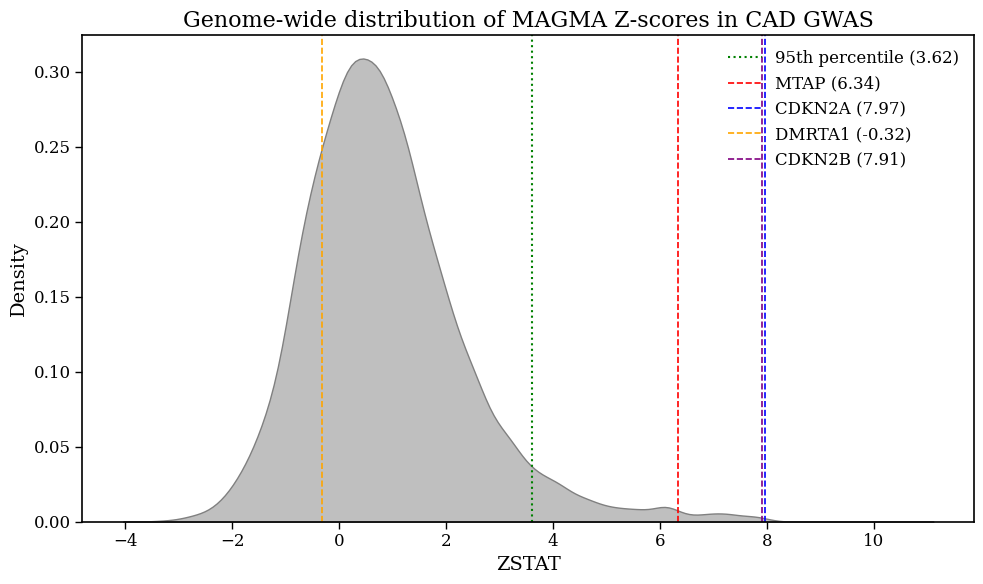

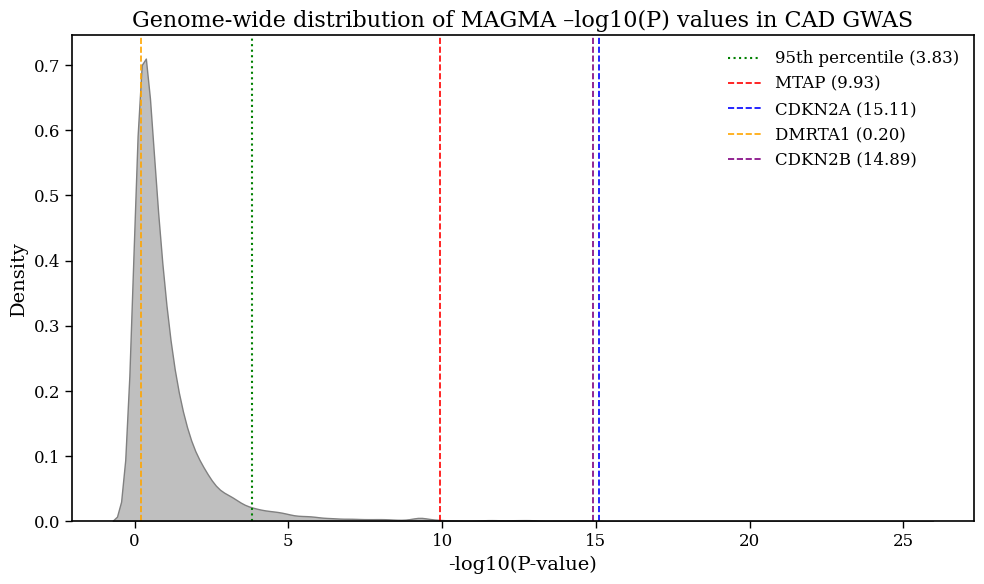

------------------------------



In [28]:
gene_loc_data = pd.read_csv(GENE_LOC_FILE_PATH, delim_whitespace=True, header=None, names=["gene_map_num", "chr", "start", "end", "strand", "gene_name"])
process_gwas_data(CAD_FILE_PATH, "CAD", OUTPUT_DIR, mapping_type='loc', gene_loc_df=gene_loc_data)

/var/folders/57/kkbdwlk56p3580bc53nf2ypr0000gp/T/ipykernel_58792/3304988798.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  magma_output = pd.read_csv(file_path, delim_whitespace=True)
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


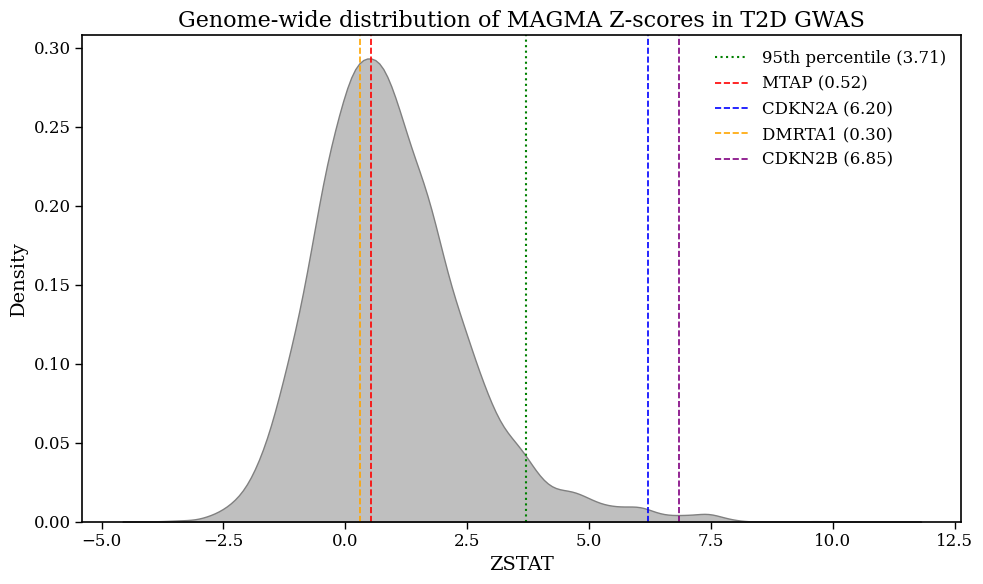

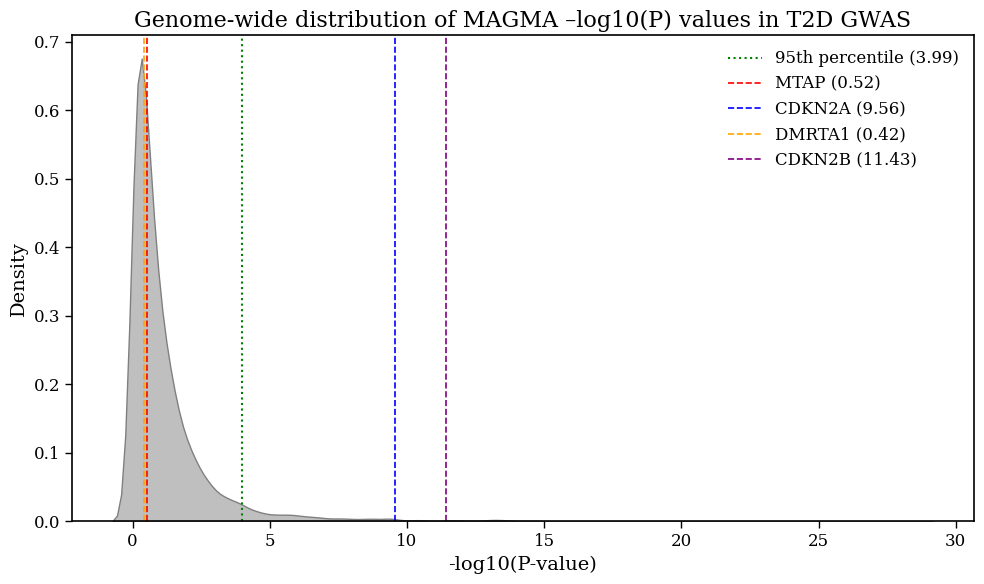

------------------------------



In [29]:
# Process T2D 
process_gwas_data(T2D_FILE_PATH, "T2D", OUTPUT_DIR, mapping_type='ensembl')

/var/folders/57/kkbdwlk56p3580bc53nf2ypr0000gp/T/ipykernel_58792/3304988798.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  magma_output = pd.read_csv(file_path, delim_whitespace=True)
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


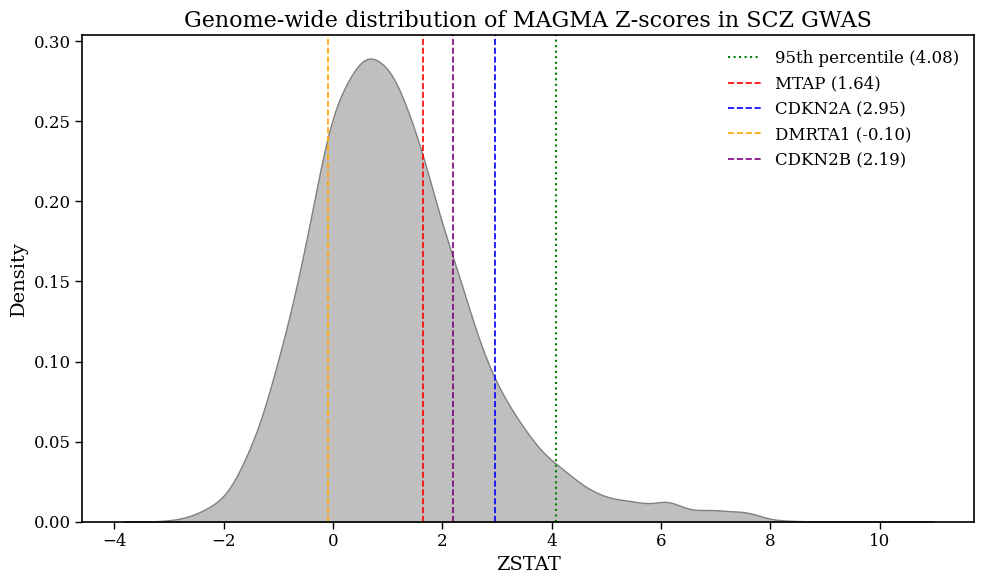

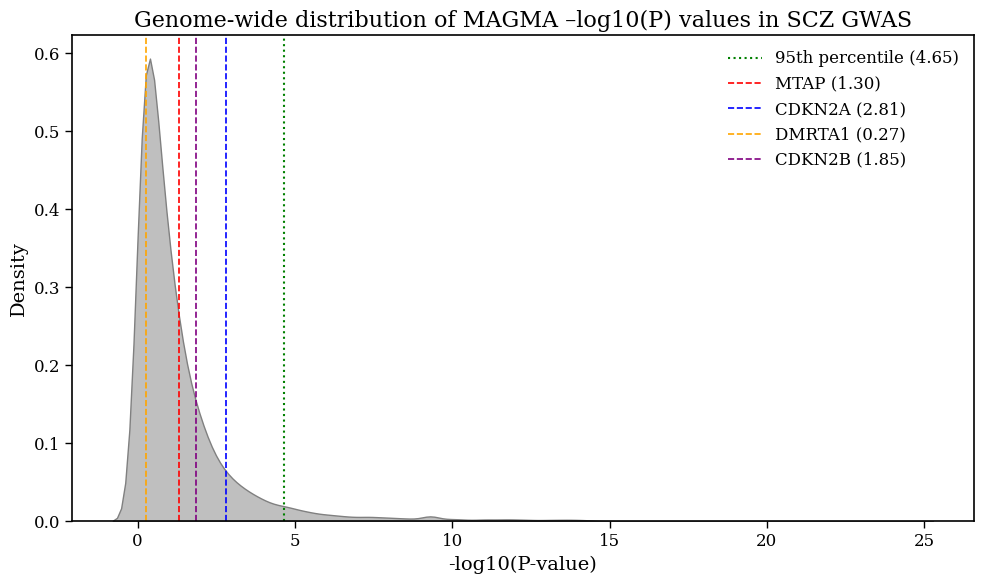

------------------------------



In [30]:
# Process SCZ 
process_gwas_data(SCZ_FILE_PATH, "SCZ", OUTPUT_DIR, mapping_type='ensembl')